In [36]:
import pandas as pd

file_path = "/Users/sahithyaravi/Downloads/ProcessedData.xlsx"  
data = pd.read_excel(file_path)

print(data.head())
print(data.info())

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55       17850  United Kingdom  
1 2010-12-01 08:26:00       3.39       17850  United Kingdom  
2 2010-12-01 08:26:00       2.75       17850  United Kingdom  
3 2010-12-01 08:26:00       3.39       17850  United Kingdom  
4 2010-12-01 08:26:00       3.39       17850  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401604 entries, 0 to 401603
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       -----------

In [38]:
data = data[data['Country'] == 'United Kingdom']
data = data.drop(columns=['Country'])
print("Filtered Data Shape:", data.shape)
print(data.head())


Filtered Data Shape: (356728, 7)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID  
0 2010-12-01 08:26:00       2.55       17850  
1 2010-12-01 08:26:00       3.39       17850  
2 2010-12-01 08:26:00       2.75       17850  
3 2010-12-01 08:26:00       3.39       17850  
4 2010-12-01 08:26:00       3.39       17850  


In [40]:
data['Month'] = data['InvoiceDate'].dt.to_period('M')

frequency_data = data.groupby(['CustomerID', 'Month']).agg({
    'InvoiceNo': 'nunique'  
}).reset_index()

frequency_data.rename(columns={'InvoiceNo': 'NumTransactions'}, inplace=True)

customer_frequency = frequency_data.groupby('CustomerID').agg({
    'NumTransactions': 'mean'  
}).reset_index()

print(customer_frequency.head())


   CustomerID  NumTransactions
0       12346         2.000000
1       12747         1.222222
2       12748        17.230769
3       12749         2.000000
4       12820         1.000000


In [42]:
customer_frequency['MonthlyPurchases'] = customer_frequency['NumTransactions'] / 12


In [44]:
def categorize_frequency(row):

    if row ['NumTransactions'] >= 3:
        return 'Frequent'
   
    elif 1 < row['NumTransactions'] < 3:
        return 'Occasional'
   
    elif row['NumTransactions'] <= 1:
        return 'Inactive'
    else:
        return 'Unknown'  
customer_frequency['FrequencySegment'] = customer_frequency.apply(categorize_frequency, axis=1)

print(customer_frequency['FrequencySegment'].value_counts()) 


FrequencySegment
Inactive      2217
Occasional    1623
Frequent       110
Name: count, dtype: int64


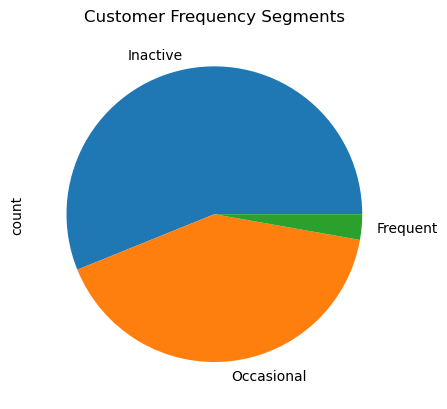

In [46]:
import matplotlib.pyplot as plt

customer_frequency['FrequencySegment'].value_counts().plot(kind='pie', color=['red', 'blue', 'green'])
plt.title("Customer Frequency Segments")

plt.show()


In [48]:
data['TotalRevenue'] = data['Quantity'] * data['UnitPrice']

print(data.head())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID    Month  TotalRevenue  
0 2010-12-01 08:26:00       2.55       17850  2010-12         15.30  
1 2010-12-01 08:26:00       3.39       17850  2010-12         20.34  
2 2010-12-01 08:26:00       2.75       17850  2010-12         22.00  
3 2010-12-01 08:26:00       3.39       17850  2010-12         20.34  
4 2010-12-01 08:26:00       3.39       17850  2010-12         20.34  


In [50]:
customer_revenue = data.groupby('CustomerID').agg({
    'TotalRevenue': 'sum'  
}).reset_index()
print(customer_revenue.head())


   CustomerID  TotalRevenue
0       12346          0.00
1       12747       4196.01
2       12748      28405.56
3       12749       3868.20
4       12820        942.34


In [52]:
customer_data = data.groupby('CustomerID').agg({
    'Quantity': 'sum',  
    'TotalRevenue': lambda x: (x * data['UnitPrice']).sum(),  
    'InvoiceNo': 'nunique',  
}).reset_index()

customer_data = customer_data.merge(customer_frequency[['CustomerID', 'FrequencySegment']], on='CustomerID')

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
customer_data['SegmentLabel'] = label_encoder.fit_transform(customer_data['FrequencySegment'])

print(label_encoder.classes_)  


['Frequent' 'Inactive' 'Occasional']


In [54]:
from sklearn.model_selection import train_test_split

X = pd.get_dummies(customer_data.drop(['CustomerID', 'FrequencySegment', 'SegmentLabel'], axis=1), drop_first=True)
y = customer_data['SegmentLabel']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (3160, 3)
Testing set size: (790, 3)


In [56]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)  


lr_model.fit(X_train, y_train)


y_pred_lr = lr_model.predict(X_test)


print("Logistic Regression - Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("Logistic Regression - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression: {accuracy_lr:.2%}")

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.16      0.28        25
           1       0.83      0.89      0.86       446
           2       0.80      0.77      0.78       319

    accuracy                           0.82       790
   macro avg       0.88      0.61      0.64       790
weighted avg       0.82      0.82      0.81       790

Logistic Regression - Confusion Matrix:
[[  4   7  14]
 [  0 399  47]
 [  0  74 245]]
Logistic Regression: 82.03%


In [58]:
from xgboost import XGBClassifier

# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')  

xgb_model.fit(X_train,y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost - Classification Report:")
print(classification_report(y_test, y_pred_xgb))

print("XGBoost - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.2%}")

XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.32      0.39        25
           1       0.83      0.86      0.84       446
           2       0.77      0.75      0.76       319

    accuracy                           0.80       790
   macro avg       0.70      0.64      0.66       790
weighted avg       0.79      0.80      0.79       790

XGBoost - Confusion Matrix:
[[  8   7  10]
 [  0 383  63]
 [  8  73 238]]
XGBoost Accuracy: 79.62%


In [60]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest: {accuracy_rf:.2%}")

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.32      0.46        25
           1       0.86      0.85      0.86       446
           2       0.76      0.81      0.78       319

    accuracy                           0.82       790
   macro avg       0.81      0.66      0.70       790
weighted avg       0.82      0.82      0.81       790

Random Forest - Confusion Matrix:
[[  8   3  14]
 [  0 381  65]
 [  2  60 257]]
Random Forest: 81.77%


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.8265822784810126
Tuned Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.36      0.51        25
           1       0.86      0.88      0.87       446
           2       0.80      0.81      0.81       319

    accuracy                           0.84       790
   macro avg       0.85      0.68      0.73       790
weighted avg       0.84      0.84      0.83       790

Tuned Random Forest - Confusion Matrix:
[[  9   5  11]
 [  0 394  52]
 [  1  60 258]]
Tuned Random Forest Accuracy: 83.67%


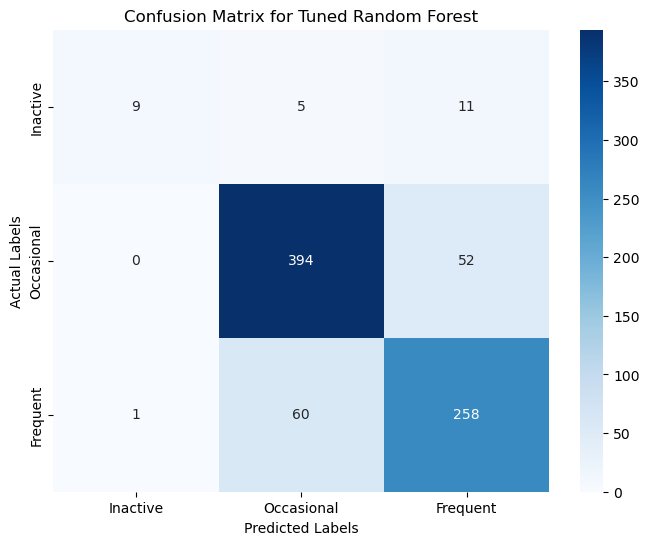

In [62]:
from sklearn.model_selection import GridSearchCV
import seaborn as sns

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],        # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],       # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],       # Minimum number of samples to split an internal node
    'min_samples_leaf': [1, 2, 4],         # Minimum number of samples to be at a leaf node
    'max_features': ['sqrt', 'log2', None] # Number of features to consider at each split
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='accuracy',  # Metric to optimize
    cv=5,                # 5-fold cross-validation
    verbose=1,           # Display progress
    n_jobs=-1            # Use all CPU cores
)

# Fit GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search_rf.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_rf.best_score_)

# Use the best model for predictions
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf_best = best_rf_model.predict(X_test)

# Evaluate the best model
print("Tuned Random Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf_best))
print("Tuned Random Forest - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_best))

# Calculate and display accuracy
accuracy_rf_best = accuracy_score(y_test, y_pred_rf_best)
print(f"Tuned Random Forest Accuracy: {accuracy_rf_best:.2%}")

cm = confusion_matrix(y_test, y_pred_rf_best)

# Define class labels (adjust according to your target labels)
class_labels = ['Inactive', 'Occasional', 'Frequent']

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix for Tuned Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()


In [64]:
import joblib

# Save the trained model to a file
joblib.dump(best_rf_model, 'tuned_random_forest_model.pkl')

print("Model saved as 'tuned_random_forest_model.pkl'")

Model saved as 'tuned_random_forest_model.pkl'


In [66]:
# Load the model from the file
loaded_model = joblib.load('tuned_random_forest_model.pkl')

print("Model loaded successfully.")

# Example: Make predictions with the loaded model
y_pred_loaded = loaded_model.predict(X_test)

Model loaded successfully.
